In [18]:
%load_ext autoreload
%autoreload

import sys
sys.path.append('..')

import os
import re
import csv

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import color.data.colors_big as dataset

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
# Choose embedding file
datasets_path = os.path.join('..', 'datasets')
emb_dir = os.path.join(datasets_path, 'embeddings')
emb_files = [os.path.join(emb_dir, f) for f in os.listdir(emb_dir)]
emb_dims = 50 # 50, 100, 200, 300
emb_file = list(filter(lambda f: str(emb_dims) in f, emb_files))[0]
emb_file

'../datasets/embeddings/glove.6B.50d.txt'

In [20]:
# Parse embeddings
emb_df = pd.read_csv(emb_file, sep=' ', engine='c', encoding='utf-8',
                     quoting=csv.QUOTE_NONE, header=None,
                     keep_default_na=False, na_values=['%%%&&&???@@@'])
vocab = emb_df[0]
emb_df.drop(0, axis=1, inplace=True)
emb_matrix = emb_df.astype('float').values
emb_dict = {vocab[i]: emb_matrix[i] for i in range(len(vocab))}

In [21]:
# Embedding Characters
emb_words = set(vocab)
emb_chars = set()
for word in emb_words:
    for char in word:
        emb_chars.add(char)
print(len(emb_chars))
#emb_chars

489


In [22]:
# Extract words from color names
color_words = set()
color_names, color_rgb = dataset.load_color_names()
print('Color map:', color_rgb.shape)
for name in color_names:
    for comps in name.split():
        color_words.add(comps.lower())
len(color_words)

Color map: (18081, 3)


9807

In [23]:
# Color names characters
color_chars = set()
for word in color_words:
    for char in word:
        color_chars.add(char)
print(len(color_chars))
# color_chars

90


In [24]:
# Overlaps
common_words = color_words & emb_words
print('Common Words: {} [{:.2f}%]'.format(len(common_words), len(common_words)*100/len(color_words)))

common_chars = color_chars & emb_chars
print('Common Characters: {} [{:.2f}%]'.format(len(common_chars), len(common_chars)*100/len(color_chars)))

print('Missing Words (50):')
print(list(color_words - emb_words)[:50])

print('Missing Characters:')
print(list(color_chars - emb_chars))


Common Words: 8300 [84.63%]
Common Characters: 88 [97.78%]
Missing Words (50):
['caperata', 'casandora', 'sōdenkaracha', 'taxite', 'fairy-nuff', 'masuhana', 'dépaysement', "nature's", 'mukluks', 'dawnstone', 'moired', 'squig', 'futaai', 'anti-flash', 'rivergrass', 'melmac', 'moelleux', 'selago', 'benimidori', 'dragée', 'kuwazome', 'golgfag', "midsummer's", 'amurense', 'breonne', 'keshizumi', '5-masted', 'amourette', 'cornsilk', 'budōnezumi', "davy's", 'daemonette', 'mandys', 'gloze', 'aureolin', 'peahen', 'y7k', 'iron-ic', "dad's", 'sigmarite', 'commandes', 'surfie', 'red-tailed-hawk', "maggie's", 'amaranthine', "bay's", 'sabiseiji', 'arragonite', 'porcellana', 'stomy']
Missing Characters:
['ǜ', 'ǎ']


In [28]:
# Get embeddings for words
# For known words (which have embeddings) just lookup the embedding
# For any other word, generate a random embedding
known_words = ['red', 'black', 'peachy', 'watermelon', 'dog']
unknown_words = ['sussie', 'truesky', "elmer's", 'skavenblight', "bunny's"]
for word in [*known_words, *unknown_words]:
    if word in emb_dict:
        known = True
        emb = np.array(emb_dict[word])
    else:
        known = False
        emb = np.random.rand(emb_dims) - 0.5  # Range (-0.5, 0.5)
    print("Word: {}, Known: {}, Emb Shape: {}\nEmbedding: {}".format(word, known, emb.shape, emb))

Word: red, Known: True, Emb Shape: (50,)
Embedding: [-0.12878   0.8798   -0.60694   0.12934   0.5868   -0.038246 -1.0408
 -0.52881  -0.29563  -0.72567   0.21189   0.17112   0.19173   0.36099
  0.032672 -0.2743   -0.19291  -0.10909  -1.0057   -0.93901  -1.0207
 -0.69995   0.57182  -0.45136  -1.2145   -1.1954   -0.32758   1.4921
  0.54574  -1.0008    2.845     0.26479  -0.49938   0.34366  -0.12574
  0.5905   -0.037696 -0.47175   0.050825 -0.20362   0.13695   0.26686
 -0.19461  -0.75482   1.0303   -0.057467 -0.32327  -0.7712   -0.16764
 -0.73835 ]
Word: black, Known: True, Emb Shape: (50,)
Embedding: [-0.96256   0.65329  -0.55152  -0.41065   0.80223   0.9833   -0.96007
 -1.029    -0.47013  -0.6812    0.071232 -0.25591   0.60577   0.29845
 -0.1837   -0.26064  -0.038707  0.11412  -0.72028  -1.2694   -0.73858
  0.3357    0.44293   0.02566  -0.97692  -1.6867   -0.88665   0.75824
  0.18836  -0.6932    2.6144    0.11718  -0.45564  -0.42953  -0.052095
  0.11656  -0.66685  -0.86056  -0.093886 -0.

In [29]:
# Check similarity b/w words
def similarity(x, y):
    return np.dot(x, y.T) / (np.sqrt(np.dot(x, x.T)) * np.sqrt(np.dot(y, y.T)))

words = [
    ['woman', 'kitchen'],
    ['woman', 'object'],
    ['woman', 'woman'],
]
for word1, word2 in words:
    emb1, emb2 = np.array(emb_dict[word1]), np.array(emb_dict[word2])
    print('Similarity b/w "{}" and "{}" is {}'.format(word1, word2, similarity(emb1, emb2)))

Similarity b/w "woman" and "kitchen" is 0.4181231013837278
Similarity b/w "woman" and "object" is 0.4139111260693676
Similarity b/w "woman" and "woman" is 1.0000000000000002


In [41]:
emb_matrix.shape

(400000, 50)

In [44]:
# Get closest words for embeddings
emb_red = np.array(['-0.12878', '0.8798', '-0.60694', '0.12934', '0.5868', '-0.038246', '-1.0408',
 '-0.52881', '-0.29563', '-0.72567', '0.21189', '0.17112', '0.19173', '0.36099',
 '0.032672', '-0.2743', '-0.19291', '-0.10909', '-1.0057', '-0.93901', '-1.0207',
 '-0.69995', '0.57182', '-0.45136', '-1.2145', '-1.1954', '-0.32758', '1.4921',
 '0.54574', '-1.0008', '2.845', '0.26479', '-0.49938', '0.34366', '-0.12574',
 '0.5905', '-0.037696', '-0.47175', '0.050825', '-0.20362', '0.13695', '0.26686',
 '-0.19461', '-0.75482', '1.0303', '-0.057467', '-0.32327', '-0.7712',
 '-0.16764', '-0.73835']).astype(np.float).reshape(50,1)

emb_random = np.random.rand(50) - 0.5  # Candidate for out of vocab words
emb_ones = np.ones_like(emb_red)  # Candidate for stop word
emb_curr = emb_red

embs_mag = np.sqrt(np.sum(emb_matrix*emb_matrix, axis=1)).reshape(-1)
emb_curr_mag = np.sqrt(np.dot(emb_curr.T, emb_curr)).reshape(-1)
emb_dot = np.dot(emb_matrix, emb_curr).reshape(-1)

embs_sim = emb_dot / (embs_mag * emb_curr_mag)

# Most similar word
print('Most similar word:', vocab[np.argmax(embs_sim)], embs_sim[np.argmax(embs_sim)])

# Most dissimilar word
print('Most dissililar word', vocab[np.argmin(embs_sim)], embs_sim[np.argmin(embs_sim)])

Most similar word: red 0.9999999999999999
Most dissililar word esber -0.7445946751683283


In [32]:
# Embedding Sample
idx = np.arange(len(emb_dict))
np.random.shuffle(idx)
samp_size = 10000
samp = emb_matrix[idx[:samp_size]]
samp.shape

(10000, 50)

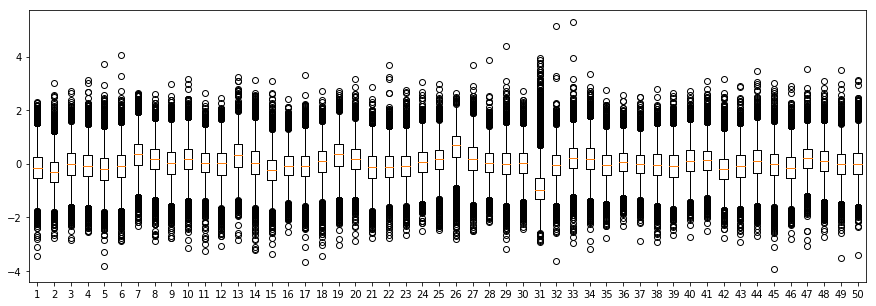

In [33]:
# Embedding Distribution
plt.figure(figsize=(15,5))
plt.boxplot(samp)
plt.show()

In [34]:
# Summary
df = pd.DataFrame(samp)
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,-0.133432,-0.282503,-0.003135,-0.058787,-0.196563,-0.089407,0.340074,0.171033,0.029996,0.173814,...,0.138563,-0.178343,-0.080396,0.084269,-0.018429,-0.138917,0.208033,0.103079,0.005544,0.016672
std,0.636808,0.609669,0.616341,0.627237,0.639316,0.666038,0.618415,0.607102,0.651614,0.617522,...,0.570207,0.599361,0.616180,0.641655,0.635511,0.620848,0.561869,0.609057,0.598462,0.632886
min,-3.462900,-2.781300,-2.830200,-2.560300,-3.826300,-2.882300,-2.335500,-2.901100,-2.770900,-3.140000,...,-2.515800,-2.764300,-2.913100,-2.698600,-3.947600,-2.826300,-3.077500,-2.741200,-3.516600,-3.415300
25%,-0.544965,-0.677438,-0.402357,-0.462342,-0.601665,-0.499713,-0.048276,-0.196128,-0.368227,-0.212317,...,-0.222745,-0.576198,-0.483497,-0.327450,-0.420593,-0.531717,-0.147257,-0.277050,-0.372987,-0.394295
50%,-0.139855,-0.304150,0.006129,-0.085865,-0.204530,-0.084393,0.356210,0.193590,0.042591,0.193415,...,0.130180,-0.205825,-0.093599,0.088252,-0.024719,-0.163365,0.205905,0.101950,-0.006402,0.009402
75%,0.272452,0.077754,0.396945,0.322980,0.199610,0.327077,0.740035,0.565277,0.444148,0.564667,...,0.486557,0.185525,0.317283,0.506415,0.384140,0.239455,0.562638,0.484035,0.376380,0.421215
max,2.310700,3.034400,2.735500,3.122300,3.725400,4.050900,2.646000,2.591600,2.977500,3.182400,...,3.075800,3.163600,2.905300,3.476400,3.019200,2.892100,3.557100,3.093800,3.505900,3.131700


In [35]:
print('IQR:', np.percentile(samp, 25), np.percentile(samp, 75))
print('Mean:', np.mean(samp))

IQR: -0.38896 0.43795
Mean: 0.021335809803594633
